In [1]:
from graph_tool.all import *
from graph_tool import generation as gt
from scipy.stats import norm
import math
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib


# Sample random graph with power-law degree sequence


n = 2000
max_degree = 20

def deg_sampler():
    accept = False
    while not accept:
        k = randint(2, max_degree)
        accept = random() < k**(-2.5)
    return k
    
    
g = gt.random_graph(n, deg_sampler, directed = False)
pos = sfdp_layout(g)

deg_distr = g.get_total_degrees(g.get_vertices())
avg_deg = np.mean(deg_distr)
avg_deg_sqr = np.mean(deg_distr**2)
print((avg_deg, avg_deg_sqr))
print(avg_deg/avg_deg_sqr) # Epidemic threshold for SIS on this network




(3.416, 18.576)
0.18389319552110248


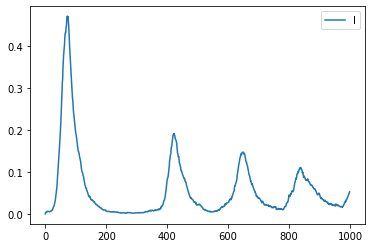

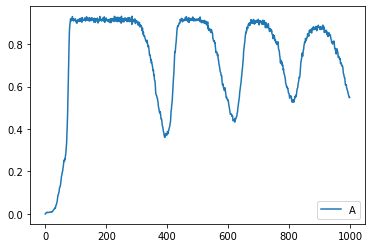

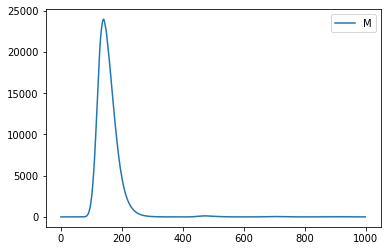

In [31]:
T = 1000
pi = 1/2 # controls relative timescale. Information has factor pi, disease factor 1 - pi
b1 = 2*(1-pi)/10 # infection rate
u1 = 2*(1-pi)/20 # recovery rate
b2 = 0*2*pi/10 # behavior change rate
u2 = 2*pi/10 #rate of reverting behavioral change
u3 = -2*pi*np.log(1/2)/14 # media decay rate, calculated such that the decay by itself has a halftime of two weeks with pi = 1/2
a1 = 0.1 # a1*b1 is the effective infection probability for adopters of protections
r1 = 1 # weight of the current infection prevalence for media growth
r2 = 0 # weight of the d-day change in infection prevalence for media growth
init_infected = 5
c = 0.6

S = 0
I = 1
N = 0 # protections not adopted
A = 1 # protections adopted



# Initialize all vertices to the S state
I_state = g.new_vertex_property("int")
for v in g.vertices():
    I_state[v] = S

#Initialize state of behavior
B_state = g.new_vertex_property("int")
for v in g.vertices():
    B_state[v] = N
    
for v in randint(0, n-1, size = init_infected): 
    I_state[v] = I

vs = list(g.vertices())

i = np.zeros(T)
a = np.zeros(T)
m = np.zeros(T)
m[0] = 0.01

n_I = init_infected
n_S = n - init_infected
n_N = n_S
n_A = n_I

def update_counts(nI_change, nA_change):
    global n_I
    global n_S
    global n_A
    global n_N
    n_I += nI_change
    n_S -= nI_change
    n_A += nA_change
    n_N -= nA_change
    

for t in range(T-1):
    for v in vs:
        if I_state[v] == S:
            b_eff = (1 if B_state[v] == N else 0.2*np.exp(-10*m[t]))*b1
            ns = [n for n in list(v.out_neighbors()) if I_state[n] == I]
            if random() < 1 - math.exp(-c*len(ns)*b_eff):
                I_state[v] = I
                update_counts(1, 0)
                if B_state[v] == N:
                    B_state[v] = A
                    update_counts(0, 1)
        elif I_state[v] == I:
            if random() < 1 - math.exp(-u1):
                I_state[v] = S
                update_counts(-1, 0)
        if B_state[v] == N:
            ns = [n for n in list(v.out_neighbors()) if B_state[n] == A]
           # maybe mechanism dependent on neighbors adoption percentage? p_A = len([n for n in list(v.out_neighbors()) if B_state[n] == A])/len(v.out_neighbors())
            if random() < 1 - np.exp(-c*len(ns)*b2) or random() < 1 - np.exp(-0.05*m[t]): #Either adoption through neighbors or spontaneously with media-dependent rate
                B_state[v] = A
                update_counts(0, 1)
        elif B_state[v] == A:
            if random() < 1 - math.exp(-u2):
                B_state[v] = N
                update_counts(0, -1)
    
    i[t+1] = n_I/n
    a[t+1] = n_A/n
    m[t+1] = m[t] + m[t]*r1*i[t] - u3*m[t]


plt.plot(range(T), i)
plt.legend(["I"])
plt.figure()
plt.plot(range(T), a)
plt.legend(["A"])
plt.figure()
plt.plot(range(T), m)
plt.legend(["M"])
plt.show()




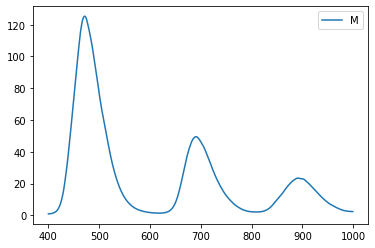

In [33]:
plt.plot(range(400, 1000), m[400:1000])
plt.legend(["M"])
plt.show()

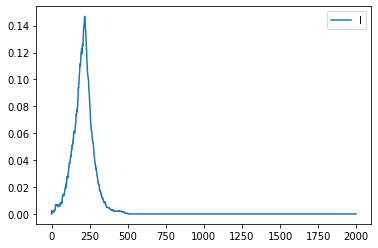

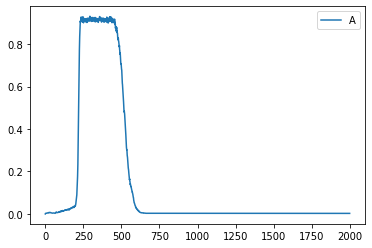

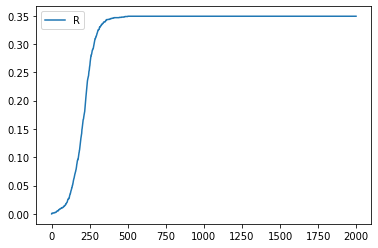

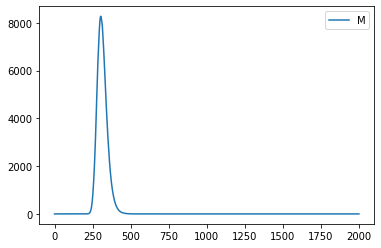

In [39]:
T = 2000
pi = 1/2 # controls relative timescale. Information has factor pi, disease factor 1 - pi
b1 = 2*(1-pi)/40 # infection rate
u1 = 2*(1-pi)/50 # recovery rate
b2 = 0*2*pi/10 # behavior change rate
u2 = 2*pi/10 #rate of reverting behavioral change
u3 = -2*pi*np.log(1/2)/14 # media decay rate, calculated such that the decay by itself has a halftime of two weeks with pi = 1/2
a1 = 0.1 # a1*b1 is the effective infection probability for adopters of protections
r1 = 2 ## weight of the current infection prevalence for media growth
r2 = 0 # weight of the d-day change in infection prevalence for media growth
c = 0.6 # contact probability, i.e. percentage of your contacts that you actually interact with on a given day
init_infected = 5

S = 0
I = 1
R = 2
N = 0 # protections not adopted
A = 1 # protections adopted



# Initialize all vertices to the S state
I_state = g.new_vertex_property("int")
for v in g.vertices():
    I_state[v] = S

#Initialize state of behavior
B_state = g.new_vertex_property("int")
for v in g.vertices():
    B_state[v] = N
    
for v in randint(0, n-1, size = init_infected): 
    I_state[v] = I

vs = list(g.vertices())

i = np.zeros(T)
r = np.zeros(T)
a = np.zeros(T)
m = np.zeros(T)
m[0] = 0.001

n_I = init_infected
n_S = n - init_infected
n_R = 0
n_N = n_S
n_A = n_I

def update_counts(nI_change, nA_change, nR_change):
    global n_I
    global n_S
    global n_A
    global n_N
    global n_R
    n_I += nI_change - nR_change
    n_S -= nI_change
    n_A += nA_change
    n_N -= nA_change
    n_R += nR_change
    

for t in range(T-1):
    for v in vs:
        if I_state[v] == S:
            b_eff = (1 if B_state[v] == N else 0.2*np.exp(-10*m[t]))*b1
            ns = [n for n in list(v.out_neighbors()) if I_state[n] == I]
            if random() < 1 - math.exp(-c*len(ns)*b_eff):
                I_state[v] = I
                update_counts(1, 0, 0)
                if B_state[v] == N:
                    B_state[v] = A
                    update_counts(0, 1, 0)
        elif I_state[v] == I:
            if random() < 1 - math.exp(-u1):
                I_state[v] = R
                update_counts(0, 0, 1)
        if B_state[v] == N:
            ns = [n for n in list(v.out_neighbors()) if B_state[n] == A]
           # maybe mechanism dependent on neighbors adoption percentage? p_A = len([n for n in list(v.out_neighbors()) if B_state[n] == A])/len(v.out_neighbors())
            if random() < 1 - np.exp(-c*len(ns)*b2) or random() < 1 - np.exp(-0.05*m[t]): #Either adoption through neighbors or spontaneously with media-dependent rate
                B_state[v] = A
                update_counts(0, 1, 0)
        elif B_state[v] == A:
            if random() < 1 - math.exp(-u2):
                B_state[v] = N
                update_counts(0, -1, 0)
    
    i[t+1] = n_I/n
    a[t+1] = n_A/n
    r[t+1] = n_R/n
    m[t+1] = m[t] + m[t]*(r1*i[t] - u3)


plt.plot(range(T), i)
plt.legend(["I"])
plt.figure()
plt.plot(range(T), a)
plt.legend(["A"])
plt.figure()
plt.plot(range(T), r)
plt.legend(["R"])
plt.figure()
plt.plot(range(T), m)
plt.legend(["M"])
plt.show()




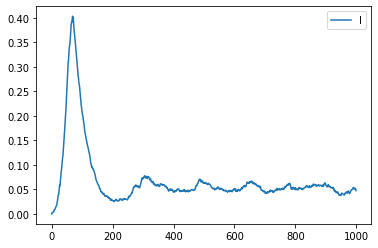

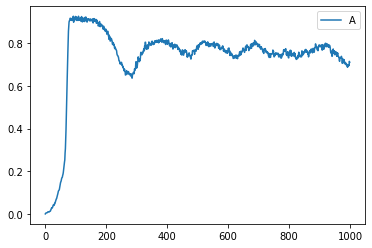

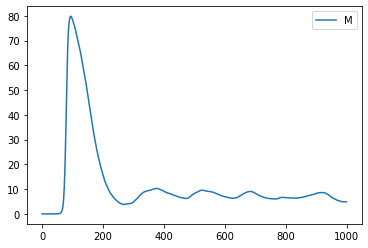

In [68]:
#WITH CARRYING CAPACITY FOR MEDIA - K
T = 1000
pi = 1/2 # controls relative timescale. Information has factor pi, disease factor 1 - pi
b1 = 2*(1-pi)/30 # infection rate
u1 = 2*(1-pi)/30 # recovery rate
b2 = 0*2*pi/10 # behavior change rate
u2 = 2*pi/10 #rate of reverting behavioral change
u3 = -2*pi*np.log(1/2)/14 # media decay rate, calculated such that the decay by itself has a halftime of two weeks with pi = 1/2
a1 = 0.1 # a1*b1 is the effective infection probability for adopters of protections
r1 = 1 # weight of the current infection prevalence for media growth
r2 = 0 # weight of the d-day change in infection prevalence for media growth
init_infected = 5
K = 100

S = 0
I = 1
N = 0 # protections not adopted
A = 1 # protections adopted



# Initialize all vertices to the S state
I_state = g.new_vertex_property("int")
for v in g.vertices():
    I_state[v] = S

#Initialize state of behavior
B_state = g.new_vertex_property("int")
for v in g.vertices():
    B_state[v] = N
    
for v in randint(0, n-1, size = init_infected): 
    I_state[v] = I

vs = list(g.vertices())

i = np.zeros(T)
a = np.zeros(T)
m = np.zeros(T)
m[0] = 0.01

n_I = init_infected
n_S = n - init_infected
n_N = n_S
n_A = n_I

def update_counts(nI_change, nA_change):
    global n_I
    global n_S
    global n_A
    global n_N
    n_I += nI_change
    n_S -= nI_change
    n_A += nA_change
    n_N -= nA_change
    

for t in range(T-1):
    for v in vs:
        if I_state[v] == S:
            b_eff = (1 if B_state[v] == N else 0.2*np.exp(-10*m[t]))*b1
            ns = [n for n in list(v.out_neighbors()) if I_state[n] == I]
            if random() < 1 - np.exp(-len(ns)*b_eff):
                I_state[v] = I
                update_counts(1, 0)
                if B_state[v] == N:
                    B_state[v] = A
                    update_counts(0, 1)
        elif I_state[v] == I:
            if random() < 1 - np.exp(-u1):
                I_state[v] = S
                update_counts(-1, 0)
        if B_state[v] == N:
            ns = [n for n in list(v.out_neighbors()) if B_state[n] == A]
           # maybe mechanism dependent on neighbors adoption percentage? p_A = len([n for n in list(v.out_neighbors()) if B_state[n] == A])/len(v.out_neighbors())
            if random() < 1 - np.exp(-len(ns)*b2) or random() < 1 - np.exp(-0.05*m[t]): #Either adoption through neighbors or spontaneously with media-dependent rate
                B_state[v] = A
                update_counts(0, 1)
        elif B_state[v] == A:
            if random() < 1 - np.exp(-u2):
                B_state[v] = N
                update_counts(0, -1)
    
    i[t+1] = n_I/n
    a[t+1] = n_A/n
    m[t+1] = m[t] + m[t]*(1 - m[t]/K)*r1*i[t] - u3*m[t]


plt.plot(range(T), i)
plt.legend(["I"])
plt.figure()
plt.plot(range(T), a)
plt.legend(["A"])
plt.figure()
plt.plot(range(T), m)
plt.legend(["M"])
plt.show()




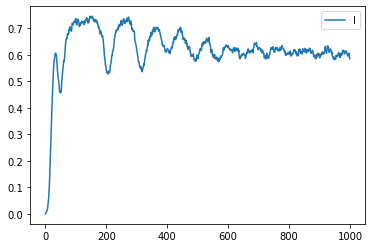

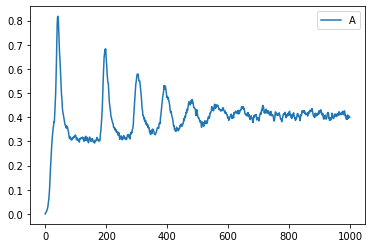

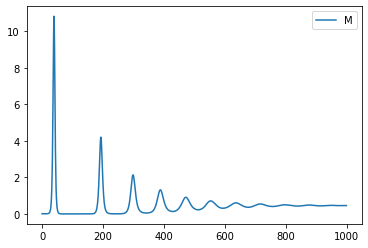

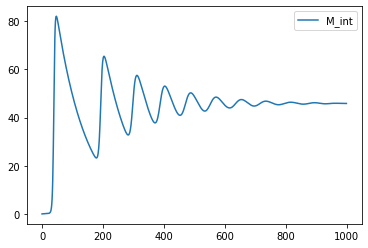

In [4]:
### WITH MEDIA ACCUMULATION CARRYING CAPACITY ###
#################################################

T = 1000
pi = 1/2 # controls relative timescale. Information has factor pi, disease factor 1 - pi
b1 = 2*(1-pi)/10 # infection rate
u1 = 2*(1-pi)/20 # recovery rate
b2 = 0*2*pi/10 # behavior change rate
u2 = 2*pi/10 #rate of reverting behavioral change
u3 = -2*pi*np.log(1/2)/14 # media decay rate, calculated such that the decay by itself has a halftime of two weeks with pi = 1/2
a1 = 0.2 # a1*b1 is the base effective infection rate for adopters of protections (with no media, worst case)
r1 = 1 # weight of the current infection prevalence for media growth
r2 = 0 # weight of the d-day change in infection prevalence for media growth
init_infected = 5
alpha = 0.99 # 1 - alpha is the decay rate of media memory
K = 50  #Carrying capacity for media accumulation (exponentially decaying terms)

S = 0
I = 1
N = 0 # protections not adopted
A = 1 # protections adopted



# Initialize all vertices to the S state
I_state = g.new_vertex_property("int")
for v in g.vertices():
    I_state[v] = S

#Initialize state of behavior
B_state = g.new_vertex_property("int")
for v in g.vertices():
    B_state[v] = N
    
for v in randint(0, n-1, size = init_infected): 
    I_state[v] = I

vs = list(g.vertices())

i = np.zeros(T)
a = np.zeros(T)
m = np.zeros(T)
Mint = np.zeros(T)
m[0] = 0.01

n_I = init_infected
n_S = n - init_infected
n_N = n_S
n_A = n_I

def update_counts(nI_change, nA_change):
    global n_I
    global n_S
    global n_A
    global n_N
    n_I += nI_change
    n_S -= nI_change
    n_A += nA_change
    n_N -= nA_change
    
M = m[0]
Mint[0] = M


for t in range(T-1):
    for v in vs:
        if I_state[v] == S:
            b_eff = (1 if B_state[v] == N else a1*np.exp(-10*m[t]))*b1
            ns = [n for n in list(v.out_neighbors()) if I_state[n] == I]
            if random() < 1 - math.exp(-len(ns)*b_eff):
                I_state[v] = I
                update_counts(1, 0)
                if B_state[v] == N:
                    B_state[v] = A
                    update_counts(0, 1)
        elif I_state[v] == I:
            if random() < 1 - math.exp(-u1):
                I_state[v] = S
                update_counts(-1, 0)
        if B_state[v] == N:
            ns = [n for n in list(v.out_neighbors()) if B_state[n] == A]
            if random() < 1 - np.exp(-len(ns)*b2) or random() < 1 - np.exp(-0.05*m[t]): #Either adoption through neighbors or spontaneously with media-dependent rate
                B_state[v] = A
                update_counts(0, 1)
        elif B_state[v] == A:
            if random() < 1 - math.exp(-u2):
                B_state[v] = N
                update_counts(0, -1)
    
    i[t+1] = n_I/n
    a[t+1] = n_A/n
    m[t+1] = m[t] + r1*m[t]*(1 - M/K)*i[t] - u3*m[t]
    M = M*alpha + m[t+1]
    Mint[t+1] = M


plt.plot(range(T), i)
plt.legend(["I"])
plt.figure()
plt.plot(range(T), a)
plt.legend(["A"])
plt.figure()
plt.plot(range(T), m)
plt.legend(["M"])
plt.figure()
plt.plot(range(T), Mint)
plt.legend(["M_int"])
plt.show()





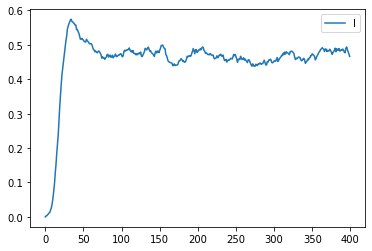

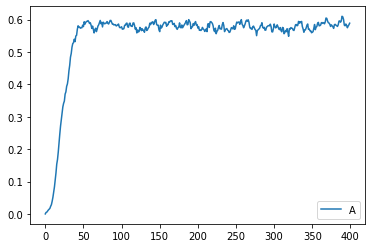

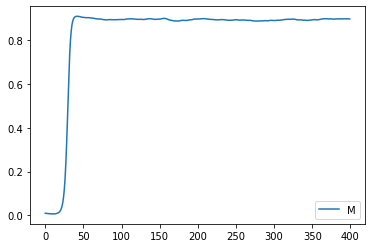

In [76]:
### MEDIA UPDATES MORE OFTEN THAN OTHER PROCESSES (THROUGH dt)###
#################################################################

T = 400
pi = 1/2 # controls relative timescale. Information has factor pi, disease factor 1 - pi
b1 = 2*(1-pi)/10 # infection rate
u1 = 2*(1-pi)/20 # recovery rate
b2 = 0*2*pi/10 # behavior change rate
u2 = 2*pi/10 #rate of reverting behavioral change
u3 = -2*pi*np.log(1/2)/14 # media decay rate, calculated such that the decay by itself has a halftime of two weeks with pi = 1/2
a1 = 0.1 # a1*b1 is the effective infection probability for adopters of protections
r1 = 1 # weight of the current infection prevalence for media growth
r2 = 0 # weight of the d-day change in infection prevalence for media growth
init_infected = 5

S = 0
I = 1
N = 0 # protections not adopted
A = 1 # protections adopted



# Initialize all vertices to the S state
I_state = g.new_vertex_property("int")
for v in g.vertices():
    I_state[v] = S

#Initialize state of behavior
B_state = g.new_vertex_property("int")
for v in g.vertices():
    B_state[v] = N
    
for v in randint(0, n-1, size = init_infected): 
    I_state[v] = I

vs = list(g.vertices())

i = np.zeros(T)
a = np.zeros(T)
m = np.zeros(T)
m[0] = 0.01

n_I = init_infected
n_S = n - init_infected
n_N = n_S
n_A = n_I

def update_counts(nI_change, nA_change):
    global n_I
    global n_S
    global n_A
    global n_N
    n_I += nI_change
    n_S -= nI_change
    n_A += nA_change
    n_N -= nA_change
    

    
dt = 0.1

for t in range(T-1):
    for v in vs:
        if I_state[v] == S:
            b_eff = (1 if B_state[v] == N else 0.2*np.exp(-10*m[t]))*b1
            ns = [n for n in list(v.out_neighbors()) if I_state[n] == I]
            if random() < 1 - math.exp(-len(ns)*b_eff):
                I_state[v] = I
                update_counts(1, 0)
                if B_state[v] == N:
                    B_state[v] = A
                    update_counts(0, 1)
        elif I_state[v] == I:
            if random() < 1 - math.exp(-u1):
                I_state[v] = S
                update_counts(-1, 0)
        if B_state[v] == N:
            ns = [n for n in list(v.out_neighbors()) if B_state[n] == A]
           # maybe mechanism dependent on neighbors adoption percentage? p_A = len([n for n in list(v.out_neighbors()) if B_state[n] == A])/len(v.out_neighbors())
            if random() < 1 - np.exp(-len(ns)*b2) or random() < 1 - np.exp(-0.1*m[t]): #Either adoption through neighbors or spontaneously with media-dependent rate
                B_state[v] = A
                update_counts(0, 1)
        elif B_state[v] == A:
            if random() < 1 - math.exp(-u2):
                B_state[v] = N
                update_counts(0, -1)
    
    i[t+1] = n_I/n
    a[t+1] = n_A/n
    
    m_temp = m[t]
    for s in range(10):
        m_temp = m_temp + (r1*i[t]*(1 - m_temp) - u3)*m_temp*dt
    m[t+1] = m_temp
    #m[t+1] = m[t] + m[t]*(1- m[t])*r1*i[t] - u3*m[t]


plt.plot(range(T), i)
plt.legend(["I"])
plt.figure()
plt.plot(range(T), a)
plt.legend(["A"])
plt.figure()
plt.plot(range(T), m)
plt.legend(["M"])
plt.show()




In [87]:
# BROWNIAN MOTION COMPONENT FOR MEDIA
T = 400
pi = 1/2 # controls relative timescale. Information has factor pi, disease factor 1 - pi
b1 = 2*(1-pi)/15 # infection rate
u1 = 2*(1-pi)/20 # recovery rate
b2 = 0*2*pi/10 # behavior change rate
u2 = 2*pi/10 #rate of reverting behavioral change
u3 = -2*pi*np.log(1/2)/14 # media decay rate, calculated such that the decay by itself has a halftime of two weeks with pi = 1/2
a1 = 0.1 # a1*b1 is the effective infection probability for adopters of protections
r1 = 1 # weight of the current infection prevalence for media growth
r2 = 0 # weight of the d-day change in infection prevalence for media growth
init_infected = 5

S = 0
I = 1
N = 0 # protections not adopted
A = 1 # protections adopted



# Initialize all vertices to the S state
I_state = g.new_vertex_property("int")
for v in g.vertices():
    I_state[v] = S

#Initialize state of behavior
B_state = g.new_vertex_property("int")
for v in g.vertices():
    B_state[v] = N
    
for v in randint(0, n-1, size = init_infected): 
    I_state[v] = I

vs = list(g.vertices())

i = np.zeros(T)
a = np.zeros(T)
m = np.zeros(T)
m[0] = 0.01

n_I = init_infected
n_S = n - init_infected
n_N = n_S
n_A = n_I

def update_counts(nI_change, nA_change):
    global n_I
    global n_S
    global n_A
    global n_N
    n_I += nI_change
    n_S -= nI_change
    n_A += nA_change
    n_N -= nA_change
    

dB = norm.rvs(size=T, scale=0.03)


for t in range(T-1):
    for v in vs:
        if I_state[v] == S:
            b_eff = (1 if B_state[v] == N else 0.2*np.exp(-10*m[t]))*b1
            ns = [n for n in list(v.out_neighbors()) if I_state[n] == I]
            if random() < 1 - math.exp(-len(ns)*b_eff):
                I_state[v] = I
                update_counts(1, 0)
                if B_state[v] == N:
                    B_state[v] = A
                    update_counts(0, 1)
        elif I_state[v] == I:
            if random() < 1 - math.exp(-u1):
                I_state[v] = S
                update_counts(-1, 0)
        if B_state[v] == N:
            ns = [n for n in list(v.out_neighbors()) if B_state[n] == A]
            if random() < 1 - np.exp(-len(ns)*b2) or random() < 1 - np.exp(-0.2*m[t]): #Either adoption through neighbors or spontaneously with media-dependent rate
                B_state[v] = A
                update_counts(0, 1)
        elif B_state[v] == A:
            if random() < 1 - math.exp(-u2):
                B_state[v] = N
                update_counts(0, -1)
    
    i[t+1] = n_I/n
    a[t+1] = n_A/n
    
    if 
    
    

    m[t+1] = m[t] + m[t]*(1- m[t])*r1*i[t] - u3*m[t] + (1 - m[t])*dB[t]


plt.plot(range(T), i)
plt.legend(["I"])
plt.figure()
plt.plot(range(T), a)
plt.legend(["A"])
plt.figure()
plt.plot(range(T), m)
plt.legend(["M"])
plt.show()




<ipython-input-87-2f243379e443>:62: RuntimeWarning: overflow encountered in exp
  b_eff = (1 if B_state[v] == N else 0.2*np.exp(-10*m[t]))*b1
<ipython-input-87-2f243379e443>:64: RuntimeWarning: invalid value encountered in double_scalars
  if random() < 1 - math.exp(-len(ns)*b_eff):
<ipython-input-87-2f243379e443>:76: RuntimeWarning: overflow encountered in exp
  if random() < 1 - np.exp(-len(ns)*b2) or random() < 1 - np.exp(-0.2*m[t]): #Either adoption through neighbors or spontaneously with media-dependent rate
<ipython-input-87-2f243379e443>:88: RuntimeWarning: overflow encountered in double_scalars
  m[t+1] = m[t] + m[t]*(1- m[t])*r1*i[t] - u3*m[t] + (1 - m[t])*dB[t]
<ipython-input-87-2f243379e443>:88: RuntimeWarning: invalid value encountered in double_scalars
  m[t+1] = m[t] + m[t]*(1- m[t])*r1*i[t] - u3*m[t] + (1 - m[t])*dB[t]


KeyboardInterrupt: 

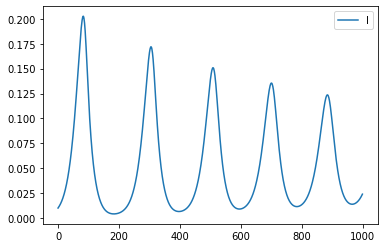

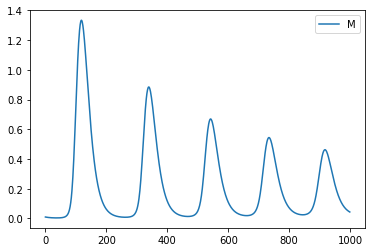

In [5]:
b1 = 1/10 # infection rate
u1 = 1/20 # recovery rate
b2 = 1/10 # behavior change rate
u2 = 1/30 # rate of reverting behavioral change
u3 = -np.log(1/2)/14 # media decay rate, calculated such that the decay by itself has a halftime of one week
a1 = 5 # a1*b1 is the effective infection rate for adopters of protections
a2 = 10  #a2*M[t] is the rate of media-induced SN -> SA transitions
r1 = 1 # weight of the current infection prevalence for media growth
r2 = 0  # weight of the d-day change in infection prevalence for media growth
dt = 1
T = 1000

I = np.zeros(T)
M = np.zeros(T)

I[0] = 0.01
M[0] = 0.01

    
for t in range(T-1):
    I[t+1] = I[t] + np.exp(-a1*M[t])*b1*(1 - I[t])*I[t]*dt - u1*I[t]*dt
    Idot = I[t] - I[t-1]
    M[t+1] = M[t] + M[t]*(r1*I[t] + r2*Idot - u3)*dt

plt.plot(range(T), I)
plt.legend(["I"])
plt.figure()
plt.plot(range(T), M)
plt.legend(["M"])
plt.show()



In [17]:
print(u1/b1)
1 - u1/b1 > u3/r1
print(1 - np.exp(a1*0.01)*u1/b1)
u3/r1
print(I[80:90])
print(M[80:100])

0.5
0.44741454096217614
[0.17599913 0.17698009 0.17747738 0.17745533 0.17688467 0.1757448
 0.17402597 0.17173117 0.16887733 0.16549569]
[0.03938767 0.04436977 0.05002556 0.05642717 0.06364674 0.07175369
 0.08081146 0.09087374 0.10198039 0.11415346 0.12739357 0.14167701
 0.15695397 0.1731481  0.19015748 0.2078569  0.22610133 0.24473017
 0.26357196 0.28244928]
